# Gaps on structure functions: **interactive pipeline demo**
1. ~~Email Marcus~~
1. ~~Get heatmap importing and exporting~~
1. Plots
    - ~~MAPE in error trend line plots (means vs. means of means)? Using these in test set eval as well as determining bias initially?~~
    - ~~Add file indexing to later plots, move to appropriate locations.~~
    - ~~Get sample size plot (add *n* to heatmaps) Especially interested in how 3d heatmaps become more populated - *how often can test intervals not find the nearest bin?*~~
    - ~~Get plots to save.~~ At earliest point in the code, whereever we're saving things, run the os func to check folder exists
1. ~~Run for 2 PSP ints for training, 1 PSP for testing.~~ See what dfs we are left with, and export the final ones.
1. ~~Run for 1 Wind testing~~
1. ~~Save and commit~~
2. ~~Move concatenation, as done as at start of step 3, from start of step 4 to start of step 5. Make step 4 run *on each test set file individually*.~~
1. ~~Divide each of the numbered steps into separate notebooks.~~ 
2. ~~Test these separate notebooks locally: 3 and 2 PSPs, 2 Wind~~
3. Convert notebooks to scripts. Note text output, make sure informative/concise enough.
4. Make quick to run on PSP vs. Wind, especially initial processing. Perhaps to just have if spacecraft =="psp": do this, elif "wind". **Remember different standardisation params!**
5. Draft some submission scripts, noting what we could use arrays for.
1. Push (new repo?) to GitHub, clone to NeSI.
9. Quick scaling study on NeSI, investigating bad ints and possible automatic removal during download or initial reading
10. Results for 1 year of PSP, 1 month of Wind
10. Up the ante to two years, **while writing up existing results**. Maybe set aside geostats stuff for now.
11. Send manuscript to Tulasi, Fraternale, Marcus
12. Implement Fraternale's sample size threshold for fitting slopes

#### Notes
- Can add smoothing to correction step alter, **not on critical path for getting most of the scripts on NESI**
- Having logarithmically spaced lag bins would make the correction factor much cleaner to work with: one-to-one bins
- For now likely to do stick with simple job arrays and single jobs on HPC, with importing and exporting of intermediate steps, but perhaps better to do single MPI script with broadcasting and reducing.
- If we tend to just get one 1 interval out of each file, could do away with (file,int) indexing
- In either case, might using actual pandas indexes be easier/more efficient?
- Add sf slope to Wind dataset

In [181]:
# Selecting one file to read in
file_index = 3
times_to_gap = 3

# 1. Download files

Run in terminal

In [182]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_201811{0200..0318}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

# 2. FOR EACH INTERVAL: standardise, duplicate, gap, calculate SFs

This will be distributed across job arrays on an HPC

## 2a. Import dependencies

In [183]:
import pickle
import pandas as pd
import numpy as np
import shutil
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="whitegrid", font_scale=1.5)
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

In [184]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

## 2b. Read in data and split into standardised intervals

Previously each core read in multiple files at a time. I think it will be better for each core to do one file at a time, especially given that each raw file contains sufficient *approximate* correlation lengths for us to then calculate the *local* outer scale and create our standardise intervals using that.

#### PSP data

In [185]:
# raw_file_list = sorted(glob.iglob(f"data/raw/psp/" + "/*.cdf"))
# raw_file_list

In [186]:
# psp_data = dif.read_cdfs(
#     [raw_file_list[file_index]],  # LIMIT HERE!
#     {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
# )
# psp_data_ready = dif.extract_components(
#     psp_data,
#     var_name="psp_fld_l2_mag_RTN",
#     label_name="label_RTN",
#     time_var="epoch_mag_RTN",
#     dim=3,
# )
# psp_df = pd.DataFrame(psp_data_ready)
# psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
#     psp_df["epoch_mag_RTN"], unit="ns"
# )
# psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

# df_raw = psp_df["B_R"].rename("B") # Giving generic name for spacecraft consistency
# print("\n")
# print(df_raw.info())

# del psp_data, psp_data_ready, psp_df

#### Wind data

In [187]:
raw_file_list = sorted(glob.iglob(f"data/raw/wind/" + "/*.cdf"))
raw_file_list

['data/raw/wind\\wi_h2_mfi_20160101_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160102_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160103_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160104_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160105_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160106_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160107_v05.cdf']

Takes about 90s/file

In [188]:
df = utils.pipeline(
    raw_file_list[file_index],
    varlist=sys_arg_dict["mag_vars"],
    thresholds=sys_arg_dict["mag_thresh"],
    cadence=sys_arg_dict["dt_hr"],
)

print("Reading {0}: {1:.1f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# Ensuring observations are in chronological order
df_wind_hr = df.sort_index()

# df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
df_wind_hr = df_wind_hr.rename(
    columns={
        params.Bwind: "Bwind",
        params.Bx: "Bx",
        params.By: "By",
        params.Bz: "Bz",
    }
)

missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

if missing > 0.4:
    # Replacing values in lists with na
    print("Large missing %")
else:
    int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

df_raw = int_wind_hr["Bx"].rename("B") # Giving generic name for spacecraft consistency

print(df_raw.info())

Reading data/raw/wind\wi_h2_mfi_20160101_v05.cdf: 4.7% missing
<class 'pandas.core.series.Series'>
DatetimeIndex: 939131 entries, 2016-01-04 00:00:00 to 2016-01-04 23:59:59.960000
Freq: 92L
Series name: B
Non-Null Count   Dtype  
--------------   -----  
939131 non-null  float32
dtypes: float32(1)
memory usage: 10.7 MB
None


The following chunk gives some metadata - not necessary for the pipeline

In [189]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.1f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 939131
Duration of interval: 0 days 23:59:59.960000
Duration between some adjacent data points:
0 days 00:00:00.092000
0 days 00:00:00.092000
0 days 00:00:00.092000

Frequency is 10.9 Hz (2dp)
Mean = -3.6836745738983154
Standard deviation = 1.3824694156646729



In [190]:
tc_approx = 2000  # s: 500 for PSP, 2000 for Wind
cadence_approx = 1 # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=30000, # 100000 for PSP, 30000 for Wind
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"Using the 1/e trick, tc was calculated to be {np.round(tc,2)}s -> data resampled to new cadence of {np.round(new_cadence,2)}s, for {tc_n}tc across {interval_length} points"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum()/len(interval) < 0.01:
            # Linear interpolate
            interval = interval.interpolate(method="linear")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)
        else:
            print("Too many NaNs in interval, skipping")


except Exception as e:
    print(f"An error occurred: {e}")

print(
    "Given this correlation length, this file yields",
    len(ints),
    "standardised interval/s")
if len(ints) > 0:
    print("These will be now decimated in",
    times_to_gap,
    "different ways")
else:
    print("NO GOOD INTERVALS WITH GIVEN SPECIFICATIONS")

Using the 1/e trick, tc was calculated to be 3214.96s -> data resampled to new cadence of 3.21s, for 10tc across 10000 points
Given this correlation length, this file yields 2 standardised interval/s
These will be now decimated in 3 different ways


In [191]:
# Delete original dataframes
del df_raw

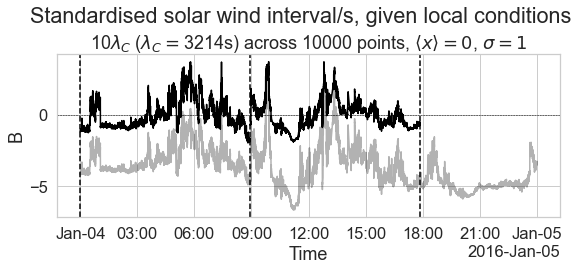

In [192]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind interval/s, given local conditions" , y= 1.1)
# Add subtitle
plt.title(f"{tc_n}$\lambda_C$ ($\lambda_C=${int(tc)}s) across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel(f"{interval.name}")

output_file_path = raw_file_list[file_index].replace("data/raw", "plots/temp").replace(".cdf", "_ints.jpg")
plt.savefig(output_file_path, bbox_inches='tight')

In [193]:
files_metadata = pd.DataFrame({
    "file_index": file_index,
    "file_start": df.index[0],
    "file_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
files_metadata

,file_index,file_start,file_end,tc,cadence
0,3,2016-01-04,2016-01-04 23:59:59,3214.96,3.21496


In [194]:
ints_metadata = pd.DataFrame({
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_metadata.reset_index(inplace=True)
ints_metadata.rename(columns={"index": "int_index"}, inplace=True)
ints_metadata.insert(0, "file_index", file_index)
ints_metadata

,file_index,int_index,int_start,int_end
0,3,0,2016-01-04 00:00:00,2016-01-04 08:55:46.785
1,3,1,2016-01-04 08:55:50,2016-01-04 17:51:36.785


## 2c. Analyse intervals (get true SF and slope)

In [195]:
lags = np.arange(1, 0.1 * len(ints[0]))

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))

powers = [2]
pwrl_range = [10,100]

In [196]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, pwrl_range)
    good_output.insert(0, "int_index", i)
    good_output.insert(1, "file_index", file_index)
    sfs = pd.concat([sfs, good_output])
    ints_metadata.loc[ints_metadata["int_index"]==i, "slope"] = slope

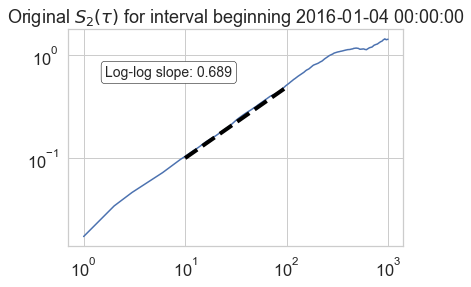

In [197]:
check_int = 0
slope = ints_metadata.loc[ints_metadata["int_index"]==check_int, "slope"].values[0]
timestamp = ints_metadata.loc[ints_metadata["int_index"]==check_int, "int_start"][0]

from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==check_int, "lag"], sfs.loc[sfs["int_index"]==check_int, "sf_2"])
pltpwrl(10,0.1, 10, 100, slope, lw=4, ls="--", color="black")
# Annotate with slope
plt.annotate(
    f"Log-log slope: {slope:.3f}",
    xy=(0.3, 0.8),
    xycoords="axes fraction",
    ha="center",
    va="center",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
    fontsize=14
)
plt.semilogx()
plt.semilogy()
plt.title(f"Original $S_2(\\tau)$ for interval beginning {timestamp}")

output_file_path = raw_file_list[file_index].replace("data/raw", "plots/temp").replace(".cdf", "_sf_example.jpg")
plt.savefig(output_file_path, bbox_inches='tight')

## 2d. Duplicate, gap, interpolate, re-analyse intervals
Gap in $x$ different ways, then calculate SF and corresponding slope for gappy (naive) and interpolated (lint) versions of each of these duplicate intervals.

In [198]:
minimum_missing_chunks = 0.7
np.random.seed(123) # For reproducibility

In [199]:
index_list = []
version_list = []
handling_list = []
missing_list = []
missing_chunks_list = []
slopes_list = []

sfs_gapped = pd.DataFrame()
ints_gapped = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_chunks, bad_input_ind_chunks, prop_removed_chunks = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        # Add the uniform gaps on top of chunks gaps 
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_chunks, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False)
        bad_output["file_index"] = file_index
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["gap_handling"] = "naive"
        sfs_gapped = pd.concat([sfs_gapped, bad_output])

        for handling in ["naive", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            missing_chunks_list.append(prop_removed_chunks*100)
            
            handling_list.append(handling)

            if handling == "naive":
                slopes_list.append(slope)
                # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df.reset_index(inplace=True)
                bad_input_df["file_index"] = file_index 
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                bad_input_df["gap_handling"] = handling
                ints_gapped = pd.concat([ints_gapped, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df.reset_index(inplace=True) # Make time a column, not an index
                interp_input_df["file_index"] = file_index
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["gap_handling"] = handling
                ints_gapped = pd.concat([ints_gapped, interp_input_df])

                interp_output["file_index"] = file_index
                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["gap_handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["n"] = bad_output["n"]
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_gapped = pd.concat([sfs_gapped, interp_output])

In [200]:
ints_gapped_metadata = pd.DataFrame({
    "file_index": file_index,
    "int_index": index_list, 
    "version": version_list, 
    "missing_percent_overall": missing_list, 
    "missing_percent_chunks": missing_chunks_list, 
    "gap_handling": handling_list})

## Export dataframes as pickle file

In [201]:
# Export the dataframes in one big pickle file
output_file_path = raw_file_list[file_index].replace("raw", "processed").replace(".cdf", ".pkl")

with open(output_file_path, "wb") as f:
    pickle.dump(
        {
            "files_metadata": files_metadata,
            "ints_metadata": ints_metadata,
            "ints": ints,
            "ints_gapped_metadata": ints_gapped_metadata,
            "ints_gapped": ints_gapped,
            "sfs": sfs,
            "sfs_gapped": sfs_gapped,
        },
        f,
    )